In [16]:
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from load_data import load_data
from model import init_model

from rsl_depth_completion.conditional_diffusion.pipeline_utils import (
    get_ds_kwargs,
    setup_train_pipeline,
)

from rsl_depth_completion.conditional_diffusion.pipeline_utils import (
    create_tracking_exp,
)
from rsl_depth_completion.conditional_diffusion.img_utils import plot_sr_samples
from rsl_depth_completion.conditional_diffusion.img_utils import center_crop

from rsl_depth_completion.conditional_diffusion.utils import print_metrics
from rsl_depth_completion.conditional_diffusion.utils import plot_full_prediction
from rsl_depth_completion.conditional_diffusion.ssl_utils import (
    calc_error_to_gt,
    plot_losses,
)
from rsl_depth_completion.models.benchmarking.calibrated_backprojection_network.kbnet import (
    eval_utils,
)
from tqdm.auto import tqdm
from rsl_depth_completion.conditional_diffusion.train_imagen_loop import sample
import numpy as np


torch.backends.cudnn.benchmark = True

In [17]:
# exp_target = "test_only_triplet"
# exp_target = "only_val_map_loss"
exp_target = "weight_val_map_loss"

logdir_name = f"presentation/{exp_target}"

out_dir = f"/tmp/{logdir_name}"
os.makedirs(out_dir, exist_ok=True)
# logdir_name = "standalone_trainer"
cfg, train_logdir = setup_train_pipeline(
    "configs/overfit.yaml", logdir_name=logdir_name, use_ssl=True
)
cfg.use_super_res = True
cfg.timesteps = 50

# cfg.disabled = True
cfg.disabled = False
cfg.input_res = 256
cfg.unets_output_res = [64, 256]
cfg.only_super_res = True
cfg.use_triplet_loss = True
cfg.batch_size = 1
cfg.other_tags = ["rerun",exp_target]

experiment = create_tracking_exp(cfg)

ds_kwargs = get_ds_kwargs(cfg)

ds, train_dataloader, val_dataloader = load_data(
    ds_name=cfg.ds_name, do_overfit=cfg.do_overfit, cfg=cfg, **ds_kwargs
)
x = ds[0]
overfit_batch = torch.utils.data.default_collate([x] * cfg.batch_size)
eval_batch = overfit_batch

# tmp, as eval_batch is not loaded from dataset
# eval_batch = ds.eval_batch
# eval_batch["rgb"] /= 255.0
# eval_batch["sdm"] *= ds.ds.max_depth
# eval_batch["gt"] = (center_crop(eval_batch["gt"], (256, 256), channels_last=False))

print(x["cond_img"].shape)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/kirilllzaitsev/rsl-depth-completion/b38fa19a577943e89746e21264b069bd



torch.Size([1, 256, 256])


In [18]:
import json
from kbnet.kbnet_model import KBNetModel
from argparse import Namespace
from kbnet.net_utils import OutlierRemoval
from kbnet.transforms import Transforms
from kbnet import eval_utils
from kbnet_utils import KBnetPredictor, load_kbnet

kbnet_predictor = load_kbnet()

In [19]:
from rsl_depth_completion.conditional_diffusion.custom_trainer_ssl import (
    ImagenTrainer as ImagenTrainerSSL,
)


unets, model = init_model(experiment, ds_kwargs, cfg, train_logdir)
trainer_kwargs = dict(
    imagen=model,
    use_lion=False,
    lr=1e-4,
    max_grad_norm=5e2,
    # fp16=cfg.fp16,
    fp16=False,
    use_ema=False,
    accelerate_log_with="comet_ml",
    accelerate_project_dir="logs",
    pose_model_restore_path=cfg.pose_model_restore_path,
)
trainer = ImagenTrainerSSL(**trainer_kwargs)
trainer_ckpt_path = "/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/conditional_diffusion/models/plain_centerline_7375-unet-2-last.pt"
# trainer_ckpt_path = "./logs/standalone_trainer/121_cfg.exp_targets=['only-sr', 'lowres-as-rescaled-256']/unet-2-last.pt"
trainer.load(
    trainer_ckpt_path,
    only_model=True,
)
# trainer.pose_model.eval()
# trainer.imagen.noise_schedulers[1].num_timesteps

print("loaded")

Using NullUnet as base unet


COMET ERROR: We failed to read file model_params.json for uploading.
Please double-check the file path and permissions


loading saved imagen at version 1.25.4, but current package version is 1.25.2
loaded


Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

unet 1 has not been trained
when sampling, you can pass stop_at_unet_number to stop early in the cascade, so it does not try to generate with untrained unets


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/models/benchmarking/calibrated_backprojection_network/kbnet/eval_utils.py:81: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((1.0 / tgt) - (1.0 / src)))
/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/models/benchmarking/calibrated_backprojection_network/kbnet/eval_utils.py:65: RuntimeWarning: divide by zero encountered in divide
  return np.sqrt(np.mean(((1.0 / tgt) - (1.0 / src)) ** 2))


unet 1 has not been trained
when sampling, you can pass stop_at_unet_number to stop early in the cascade, so it does not try to generate with untrained unets


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

unet 1 has not been trained
when sampling, you can pass stop_at_unet_number to stop early in the cascade, so it does not try to generate with untrained unets


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

unet 1 has not been trained
when sampling, you can pass stop_at_unet_number to stop early in the cascade, so it does not try to generate with untrained unets


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

unet 1 has not been trained
when sampling, you can pass stop_at_unet_number to stop early in the cascade, so it does not try to generate with untrained unets


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

unet 1 has not been trained
when sampling, you can pass stop_at_unet_number to stop early in the cascade, so it does not try to generate with untrained unets


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

unet 1 has not been trained
when sampling, you can pass stop_at_unet_number to stop early in the cascade, so it does not try to generate with untrained unets


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

unet 1 has not been trained
when sampling, you can pass stop_at_unet_number to stop early in the cascade, so it does not try to generate with untrained unets


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

unet 1 has not been trained
when sampling, you can pass stop_at_unet_number to stop early in the cascade, so it does not try to generate with untrained unets


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

unet 1 has not been trained
when sampling, you can pass stop_at_unet_number to stop early in the cascade, so it does not try to generate with untrained unets


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

unet 1 has not been trained
when sampling, you can pass stop_at_unet_number to stop early in the cascade, so it does not try to generate with untrained unets


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

unet 1 has not been trained
when sampling, you can pass stop_at_unet_number to stop early in the cascade, so it does not try to generate with untrained unets


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

unet 1 has not been trained
when sampling, you can pass stop_at_unet_number to stop early in the cascade, so it does not try to generate with untrained unets


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

unet 1 has not been trained
when sampling, you can pass stop_at_unet_number to stop early in the cascade, so it does not try to generate with untrained unets


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

unet 1 has not been trained
when sampling, you can pass stop_at_unet_number to stop early in the cascade, so it does not try to generate with untrained unets


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

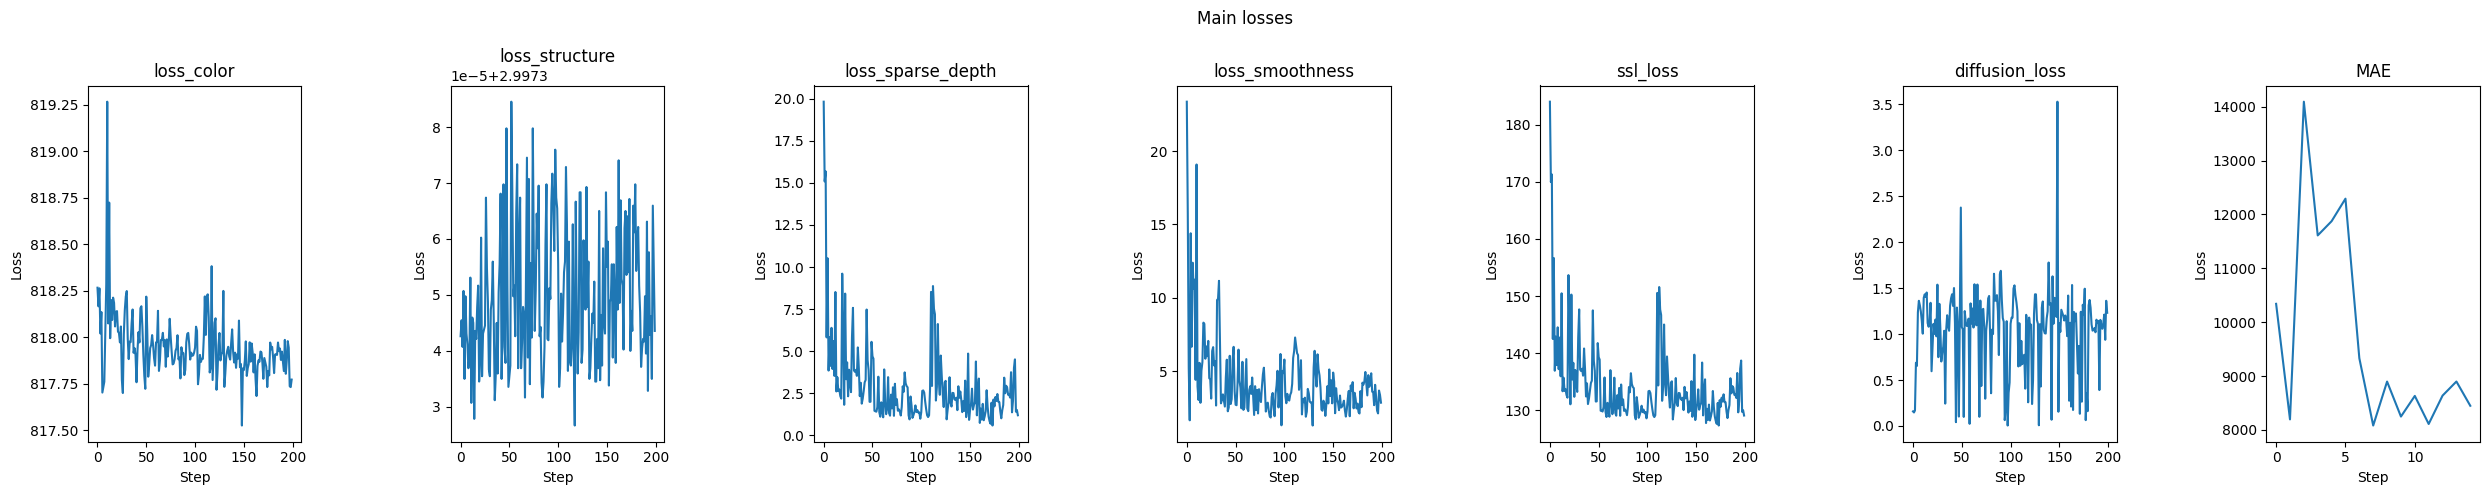

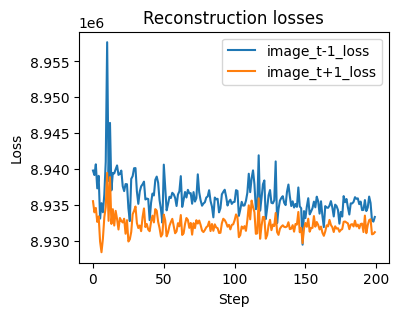

Evaluation results (train_loop-weight_val_map_loss)
Lowest MAE: 8080.8193359375
     MAE      RMSE      iMAE     iRMSE
9712.036  11836.084       inf       inf
     +/-       +/-       +/-       +/-
1818.290  2335.306       nan       nan
Saved results to /media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/conditional_diffusion/logs/presentation/weight_val_map_loss/train_loop-weight_val_map_loss.csv


/opt/miniconda3/envs/ssdc/lib/python3.10/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [20]:

start_image_or_video = eval_batch["lowres_img"]
# trainer.imagen.noise_schedulers[unet_idx-1].num_timesteps = 600
# cfg.cond_scale = 4

global_step = 0
batch_size = train_dataloader.batch_size
unet_idx = 2
rec_losses = {
    "image_01_loss": [],
    "image_02_loss": [],
}
losses = {
    "loss_color": [],
    "loss_structure": [],
    "loss_sparse_depth": [],
    "loss_smoothness": [],
    "triplet_loss": [],
    "imagen_loss": [],
    "MAE": [],
    "RMSE": [],
    "IMAE": [],
    "IRMSE": [],
}
output_depths = []
parameters_pose_model = list(trainer.pose_model.parameters())
parameters_depth_model = list(trainer.parameters())
depth_grads = {k: [] for k in range(len(parameters_depth_model))}
pose_grads = {k: [] for k in range(len(parameters_pose_model))}

validity_map_depth = torch.where(
    eval_batch["sdm"] > 0, torch.ones_like(eval_batch["sdm"]), eval_batch["sdm"]
).bool()

num_epochs = 200
# plot_epochs = [num_epochs // 2, num_epochs - 1]
plot_epochs = [num_epochs - 1]

progress_bar = tqdm(range(num_epochs), desc="Epoch")
for epoch in progress_bar:
    # progress_bar.set_description(f"Unet {unet_idx}\tEpoch {epoch}")
    images = eval_batch["input_img"]
    text_embeds = eval_batch["text_embed"]
    cond_images = eval_batch["cond_img"]

    forwards_kwargs = dict(
        images=images,
        text_embeds=text_embeds,
        cond_images=cond_images,
        unet_number=unet_idx,
        max_batch_size=cfg.max_batch_size,
        validity_map_depth=validity_map_depth
        # use_max_times=True
    )

    adj_imgs = eval_batch["adj_imgs"]

    ssl_kwargs = dict(
        image0=eval_batch["rgb"],
        image1=adj_imgs[:, 0],
        image2=adj_imgs[:, 1],
        filtered_sparse_depth0=eval_batch["sdm"],
        filtered_validity_map_depth0=validity_map_depth,
        intrinsics=eval_batch["intrinsics"],
        rec_losses=rec_losses,
        losses=losses,
    )
    forwards_kwargs.update(ssl_kwargs)

    loss, output_depth = trainer(**forwards_kwargs)
    progress_bar.set_postfix(loss=loss)

    for i in range(len(parameters_depth_model)):
        if parameters_depth_model[i].grad is not None:
            depth_grads[i].append(
                torch.sum(torch.abs(parameters_depth_model[i].grad)).item()
            )
    for i in range(len(parameters_pose_model)):
        if parameters_pose_model[i].grad is not None:
            pose_grads[i].append(
                torch.sum(torch.abs(parameters_pose_model[i].grad)).item()
            )

    trainer.update(unet_number=unet_idx)

    if epoch in np.linspace(0, num_epochs, 15, dtype=int) or epoch == num_epochs-1:
    # if False:
        output_depth_sample = sample(
            cfg,
            trainer,
            out_dir,
            eval_batch,
            1,
            start_at_unet_number=unet_idx,
            start_image_or_video=start_image_or_video,
            stop_at_unet_number=unet_idx + 1,
            experiment=experiment,
        )[0]

        mae, rmse, imae, irmse = calc_error_to_gt(output_depth_sample, eval_batch["gt"])

        losses["MAE"].append(mae.item())
        losses["RMSE"].append(rmse.item())
        losses["IMAE"].append(imae.item())
        losses["IRMSE"].append(irmse.item())

        global_step += 1

        for stats in [losses, rec_losses]:
            for k, v in stats.items():
                experiment.log_metric(f"step/{k}", v[-1], step=global_step)

        output_depths.append(output_depth_sample)

    if epoch in plot_epochs:
        losses_to_plot = {k: v for k, v in losses.items() if k not in  ['RMSE', 'IRMSE', 'IMAE']}
        plot_losses(losses_to_plot, rec_losses)

    # if epoch == 3:
    #     break
print_metrics(
    losses["MAE"],
    losses["RMSE"],
    losses["IMAE"],
    losses["IRMSE"],
    comment=f"train_loop-{exp_target}",
    save_csv=True,
    save_csv_dir=train_logdir,
)

In [21]:
# from rsl_depth_completion.conditional_diffusion.ssl_utils import plot_grads

# plot_grads(depth_grads, pose_grads, topk=None, bottomk=None)
# plot_grads(depth_grads, pose_grads, topk=None, bottomk=5)

In [22]:
# from PIL import Image
# import matplotlib.pyplot as plt
# import glob
# import torch


# output_depths = []
# for path in glob.glob('/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/conditional_diffusion/logs/presentation/test_full_triplet2/0/epoch_*.png'):

#     output_depth=torch.from_numpy(np.array(Image.open(path))).unsqueeze(0)
#     output_depths.append(output_depth)
# plt.imshow(output_depths[-1])

[<Figure size 2000x1000 with 15 Axes>]

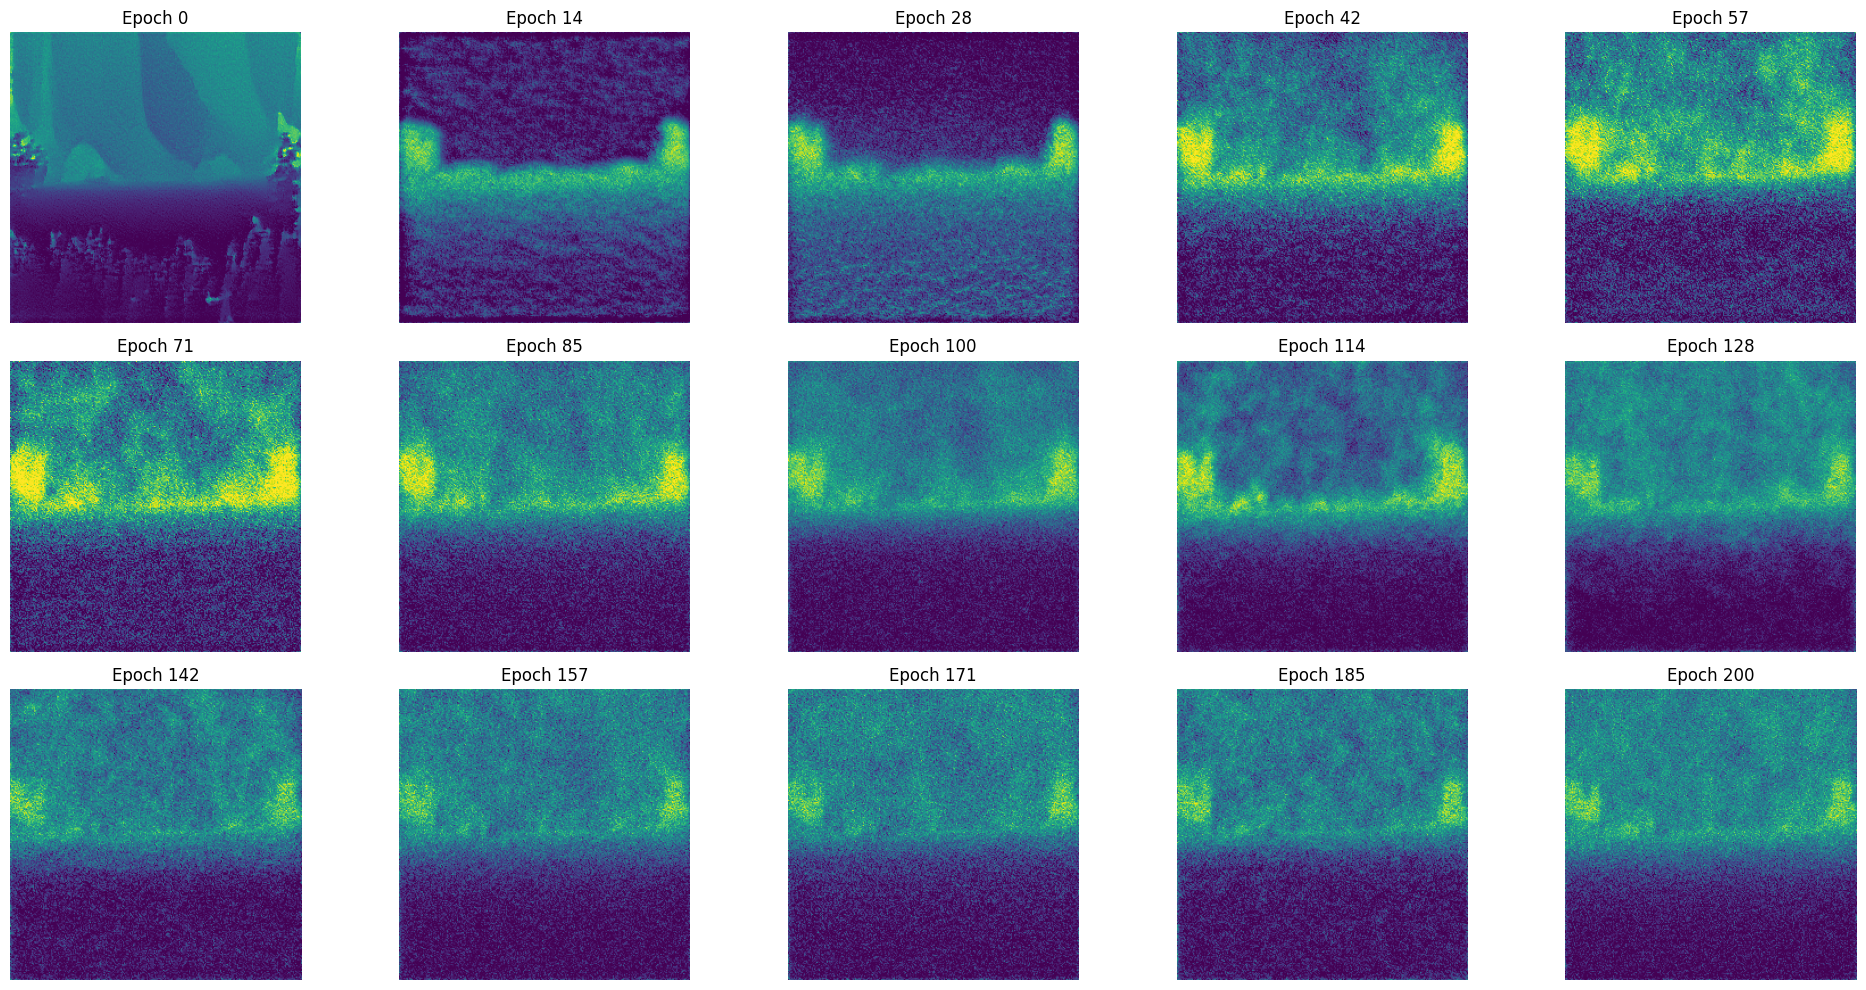

In [23]:
import numpy as np

from rsl_depth_completion.conditional_diffusion.ssl_utils import (
    plot_train_depths_overall,
)

# plot_train_depths_overall(output_depths)
plot_train_depths_overall(
    output_depths,
    # save_dir="logs/presentation",
    # save_subdir_prefix=exp_target,
    ckpts=np.linspace(0,num_epochs,15).astype(int)
)
# plot_train_depths_overall([output_depths[0]])

In [24]:
import glob
import os
import imageio
import re
import matplotlib.cm as cm

frames = []
# base_dir = "/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/conditional_diffusion/logs/standalone_trainer/121_cfg.exp_targets=['only-sr', 'lowres-as-rescaled-256']"
res_dir_path = f"/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/conditional_diffusion/logs/presentation/{exp_target}"
sample_pattern = r"\d+"
for sample_dir in sorted(os.listdir(res_dir_path)):
    if re.match(sample_pattern, sample_dir) is None:
        continue
    base_dir = f"{res_dir_path}/{sample_dir}"
    # pattern = r"sample-(\d+)-unet-\d+\.png"
    pattern = r"epoch_\d+\.png"
    for filename in sorted(os.listdir(base_dir)):
        if re.match(pattern, filename) is None:
            continue
        image = imageio.v2.imread(f"{base_dir}/{filename}")
        colored_image = cm.viridis(image)

        # Convert to 8-bit RGB image
        colored_image = (255 * colored_image).astype(np.uint8)
        frames.append(colored_image)
    assert (len(frames)) > 0, "No frames found"
    gif_path = f"{base_dir}.gif"
    imageio.mimsave(
        gif_path, frames, duration=500  # output gif  # array of input frames
    )
    print(f"Saved gif to {gif_path}")

In [25]:
from rsl_depth_completion.conditional_diffusion.train_imagen_loop import sample

unet_idx = 2
start_image_or_video = eval_batch["lowres_img"]
# trainer.imagen.noise_schedulers[unet_idx-1].num_timesteps = 600
cfg.cond_scale = 4
samples_lowres = sample(
    cfg,
    trainer,
    out_dir,
    eval_batch,
    1,
    start_at_unet_number=unet_idx,
    start_image_or_video=start_image_or_video,
    stop_at_unet_number=unet_idx + 1,
    experiment=experiment,
)

unet 1 has not been trained
when sampling, you can pass stop_at_unet_number to stop early in the cascade, so it does not try to generate with untrained unets


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

Saved rgb for prediction to /media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/conditional_diffusion/logs/presentation/weight_val_map_loss/preds/img_0.png


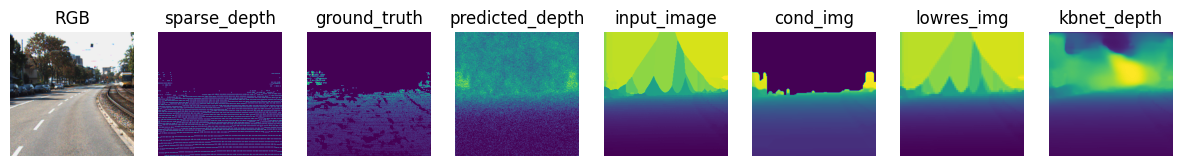

Evaluation results (trainer)
Lowest MAE: 8152.10302734375
     MAE      RMSE      iMAE     iRMSE
8152.103  9780.641       inf       inf
     +/-       +/-       +/-       +/-
   0.000     0.000       nan       nan
Saved results to /media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/conditional_diffusion/logs/presentation/weight_val_map_loss/trainer.csv
Evaluation results (kbnet)
Lowest MAE: 275.6687316894531
     MAE      RMSE      iMAE     iRMSE
 275.669   978.153     0.658     1.012
     +/-       +/-       +/-       +/-
   0.000     0.000     0.000     0.000
Saved results to /media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/conditional_diffusion/logs/presentation/weight_val_map_loss/kbnet.csv


/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/models/benchmarking/calibrated_backprojection_network/kbnet/eval_utils.py:81: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((1.0 / tgt) - (1.0 / src)))
/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/models/benchmarking/calibrated_backprojection_network/kbnet/eval_utils.py:65: RuntimeWarning: divide by zero encountered in divide
  return np.sqrt(np.mean(((1.0 / tgt) - (1.0 / src)) ** 2))


[<Figure size 1500x500 with 8 Axes>]

In [26]:
plot_full_prediction(
    eval_batch=eval_batch,
    output_depths=samples_lowres[0],
    kbnet_predictor=kbnet_predictor,
    save_csv_dir=train_logdir,
    # idx_to_use=-1,
)

In [27]:
for k, vs in losses.items():
    for idx, v in enumerate(vs):
        experiment.log_metric(f"step/{k}", v, step=idx)

In [28]:
for idx, fig in enumerate(figs):
    experiment.log_figure(figure_name=f"preds_{idx}", figure=fig)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 for idx, fig in enumerate(figs):                                                             │
│   2 │   experiment.log_figure(figure_name=f"preds_{idx}", figure=fig)                            │
│   3                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'figs' is not defined

In [29]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/kirilllzaitsev/rsl-depth-completion/b38fa19a577943e89746e21264b069bd
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     step/IMAE                    : inf
COMET INFO:     step/IRMSE                   : inf
COMET INFO:     step/MAE [30]                : (8080.8193359375, 14092.5478515625)
COMET INFO:     step/RMSE [30]               : (9556.3173828125, 16939.107421875)
COMET INFO:     step/image_01_loss [15]      : (8933275.0, 8939798.0)
COMET INFO:     step/image_02_loss [15]      : (8931208.0, 8935525.0)
COMET INFO:     step/imagen_loss [215]       : (0.004984068218618631, 3.527576208114624)
COMET INFO:     step/loss_col

In [ ]:
# from collections import defaultdict
# from functools import partial
# from kbnet.kbnet_model import KBNetModel

# from rsl_depth_completion.conditional_diffusion.custom_imagen_pytorch_ssl import exists
# from rsl_depth_completion.conditional_diffusion.custom_trainer_ssl import cast_torch_tensor, split_args_and_kwargs

# unet_number = trainer.validate_unet_number(unet_idx)
# trainer.validate_and_set_unet_being_trained(unet_number)
# trainer.set_accelerator_scaler(unet_number)

# assert (
#     not exists(trainer.only_train_unet_number)
#     or trainer.only_train_unet_number == unet_number
# ), f"you can only train unet #{trainer.only_train_unet_number}"

# total_loss = 0.0
# output_depths = []
# trainer.min_predict_depth = 1.5
# trainer.max_predict_depth = 100
# kwargs={**forwards_kwargs}
# rec_losses = kwargs.pop("rec_losses", defaultdict(lambda: list()))
# losses = kwargs.pop("losses", defaultdict(lambda: list()))

# kwargs.pop("max_batch_size")
# kwargs.pop("unet_number")

# @partial(cast_torch_tensor, cast_fp16=True)
# def forward(self, *args, unet_number=None, max_batch_size=None, **kwargs):
#     return trainer.imagen(
#                 *args,
#                 unet=trainer.unet_being_trained,
#                 unet_number=unet_number,
#                 **kwargs,
#             )

# trainer.pose_optimizer.zero_grad()
# for chunk_size_frac, (chunked_args, chunked_kwargs) in split_args_and_kwargs(
#     *[], split_size=1, **kwargs
# ):
#     with trainer.accelerator.autocast():
#         image0 = chunked_kwargs.pop("image0")
#         image1 = chunked_kwargs.pop("image1")
#         image2 = chunked_kwargs.pop("image2")
#         filtered_sparse_depth0 = chunked_kwargs.pop("filtered_sparse_depth0")
#         filtered_validity_map_depth0 = chunked_kwargs.pop(
#             "filtered_validity_map_depth0"
#         )
#         intrinsics = chunked_kwargs.pop("intrinsics").float()
#         pose01 = trainer.pose_model.forward(image0, image1)
#         pose02 = trainer.pose_model.forward(image0, image2)

#         imagen_loss, output_depth = forward(
#             trainer,
#             *chunked_args,
#             # unet=trainer.unet_being_trained,
#             unet_number=unet_number,
#             **chunked_kwargs,
#         )
#         output_depth0 = torch.sigmoid(output_depth)
#         output_depth0 = trainer.min_predict_depth / (
#             output_depth0 + trainer.min_predict_depth / trainer.max_predict_depth
#         )

#         # Compute loss function
#         triplet_loss, loss_info = KBNetModel.compute_loss(
#             image0=image0.cuda(),
#             image1=image1.cuda(),
#             image2=image2.cuda(),
#             output_depth0=output_depth0.cuda(),
#             sparse_depth0=filtered_sparse_depth0.cuda(),
#             validity_map_depth0=filtered_validity_map_depth0.cuda(),
#             intrinsics=intrinsics.cuda(),
#             pose01=pose01.cuda(),
#             pose02=pose02.cuda(),
#         )

#         loss = triplet_loss
#         # loss = imagen_loss
#         # loss = 0.3*imagen_loss + 0.7*triplet_loss

#         loss = loss * chunk_size_frac

#         image01 = loss_info['image01'].detach().cpu()
#         image02 = loss_info['image02'].detach().cpu()
#         image01_error_summary = torch.sum(
#             torch.mean(torch.abs(image0 - image01), dim=1, keepdim=False)
#         ).item()
#         image02_error_summary = torch.sum(
#             torch.mean(torch.abs(image0 - image02), dim=1, keepdim=False)
#         ).item()
#         # print("image01 reconstruction L1 loss: ", image01_error_summary)
#         # print("image02 reconstruction L1 loss: ", image02_error_summary)
#         rec_losses["image_01_loss"].append(image01_error_summary)
#         rec_losses["image_02_loss"].append(image02_error_summary)

#         loss_keys = [k for k in loss_info.keys() if "loss" in k]
#         for loss_key in loss_keys:
#             # print(f"{loss_key}: {loss_info[loss_key]}")
#             losses[loss_key].append(loss_info[loss_key].item())

#     output_depths.append(output_depth0.detach().cpu())
#     total_loss += loss.item()

#     if trainer.training:
#         trainer.accelerator.backward(loss)
#     print(trainer.pose_model.parameters()[0].grad)
#     print(next(trainer.parameters()).grad)